# Tutorial 2: P22 Mouse Brain (ATAC + RNA)

Welcome to this tutorial on using the `mTopic` package for spatial multimodal topic modeling of the P22 mouse brain dataset with ATAC and RNA modalities.

In this tutorial, we will walk through the following steps:

- Scaling and normalizing the data,
- Applying spatial multimodal topic modeling to identify distinct cell populations and explore their functional roles,
- Visualizing the results to gain insight into the spatial distribution of topics and cell types within the tissue.

Let us begin by importing the required libraries and downloading the filtered training data, available at [Zenodo](https://doi.org/10.5281/zenodo.15471869).

In [1]:
import mtopic

! wget -O P22_Mouse_Brain_ATAC_RNA_filtered.h5mu \
  "https://zenodo.org/records/15471869/files/P22_Mouse_Brain_ATAC_RNA_filtered.h5mu?download=1"

--2025-05-20 14:53:45--  https://zenodo.org/records/15471869/files/P22_Mouse_Brain_ATAC_RNA_filtered.h5mu?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40187281 (38M) [application/octet-stream]
Saving to: ‘P22_Mouse_Brain_ATAC_RNA_filtered.h5mu’

P22_Mouse_Brain_ATA 100%[===================>]  38.33M  19.8MB/s    in 1.9s    

2025-05-20 14:53:48 (19.8 MB/s) - ‘P22_Mouse_Brain_ATAC_RNA_filtered.h5mu’ saved [40187281/40187281]



## Spatial Multimodal Topic Modeling

Load the prefiltered `MuData` object containing the dataset. This dataset includes 9,215 spatial spots and two modalities:

- `atac`: chromatin accessibility data,
- `rna`: gene expression data.

In [2]:
p22 = mtopic.read.h5mu('P22_Mouse_Brain_ATAC_RNA_filtered.h5mu')

p22

MuData object with n_obs × n_vars = 9215 × 60000
  var:	'n_counts'
  obsm:	'coords'
  2 modalities
    rna:	9215 x 10000
      obs:	'n_counts'
      var:	'n_counts'
    atac:	9215 x 50000
      obs:	'n_counts'
      var:	'n_counts'

Before training the spatial Multimodal Topic Model (`mtopic.tl.sMTM`), it is essential to preprocess the data to improve the model's ability to identify meaningful patterns across modalities.

To ensure comparability between ATAC and RNA data, we apply the following normalization and scaling steps:

- **TF-IDF transformation both ATAC and RNA** (`mtopic.pp.tfidf`):  
  Adjusts raw counts by balancing feature frequency and importance, emphasizing rare but informative peaks/genes.

- **Scaling across modalities** (`mtopic.pp.scale_counts`):  
  Linearly scales counts to ensure all modalities contribute equally during topic modeling, preventing one from dominating the analysis.

In [3]:
mtopic.pp.tfidf(p22, mod='atac')
mtopic.pp.tfidf(p22, mod='rna')
mtopic.pp.scale_counts(p22)

Now that the data is preprocessed, we can train the spatial Multimodal Topic Model (`sMTM`). This model identifies coordinated patterns (topics) across modalities while incorporating spatial information. It captures co-expression of peaks and genes, revealing distinct cell populations and their functional states.

- **Initialize the model**:  
  Create an instance of the `mtopic.tl.sMTM` class, specifying the number of topics (`n_topics`) and other parameters. We use 50 topics for this tutorial.

- **Train the model**:  
  Fit the model using variational inference (`VI`). This iterative process updates the model parameters to explain the observed data. While training time depends on dataset size, `sMTM` is optimized for scalability. While we use 500 iterations in this tutorial for thorough training, the model often converges to meaningful topics in as few as 20 iterations. You can adjust the number of iterations based on dataset size and desired precision.

In [4]:
sMTM = mtopic.tl.sMTM(p22, n_topics=50, radius=0.06, n_jobs=100)
sMTM.VI(n_iter=500)

100%|███████████████████████████████████████| 500/500 [1:35:02<00:00, 11.41s/it]


After training, export the learned parameters to the `MuData` object using `mtopic.pp.export_params`:

- **Topic-spot distribution** (`gamma`, saved as `ton.obsm['topics']`):  
  Represents the distribution of topics within each cell or spot. These distributions help identify which topics are active in different tissue regions.

- **Feature-topic distributions** (`lambda`, saved as `ton[modality].varm['signatures']`):  
  Indicate the modality-specific importance of each feature for each topic. These distributions help interpret the biological meaning of the topics.

In [5]:
mtopic.tl.export_params(sMTM, p22)

The `mtopic.pp.export_params` function not only exports model parameters but can also filter out insignificant topics based on their overall contribution.

- **Topic filtering**:  
  Set `filter_topics=True` to automatically remove topics with low overall probabilities in topic-spot distribution. The `filter_threshold` parameter controls the minimum average topic probability required to retain a topic.

This helps remove spurious or noise-driven topics, simplifying downstream interpretation and visualization.

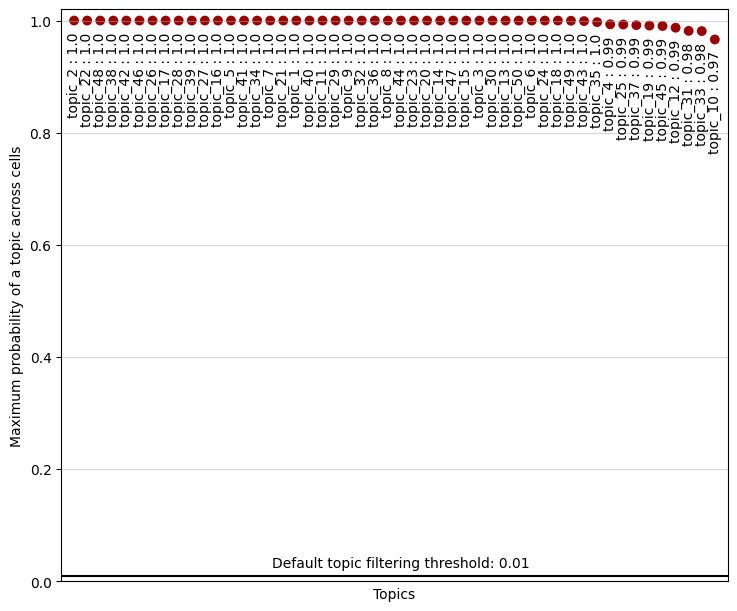

In [6]:
mtopic.pl.filter_topics(sMTM)

By preprocessing the data, training the `sMTM` model, and exporting the learned parameters, we have set the stage for a comprehensive analysis of heterogeneity within the tissue.

## Visualizing Topic-Spot Distribution

Visualizing topic distribution across cells or spatial spots is key in interpreting topic modeling results. This distribution reflects the contribution of each topic to each cell. They can reveal spatially organized cell states, types, or biological processes.

To visualize topic-spot distribution, use the `mtopic.pl.topics` function to generate scatter plots where each cell or spot is colored according to the probability of the selected topic. This reveals spatial patterns and gradients that help interpret biological variation within the tissue.

For example, if a topic captures a specific cell type, the plot will highlight regions enriched in that population.

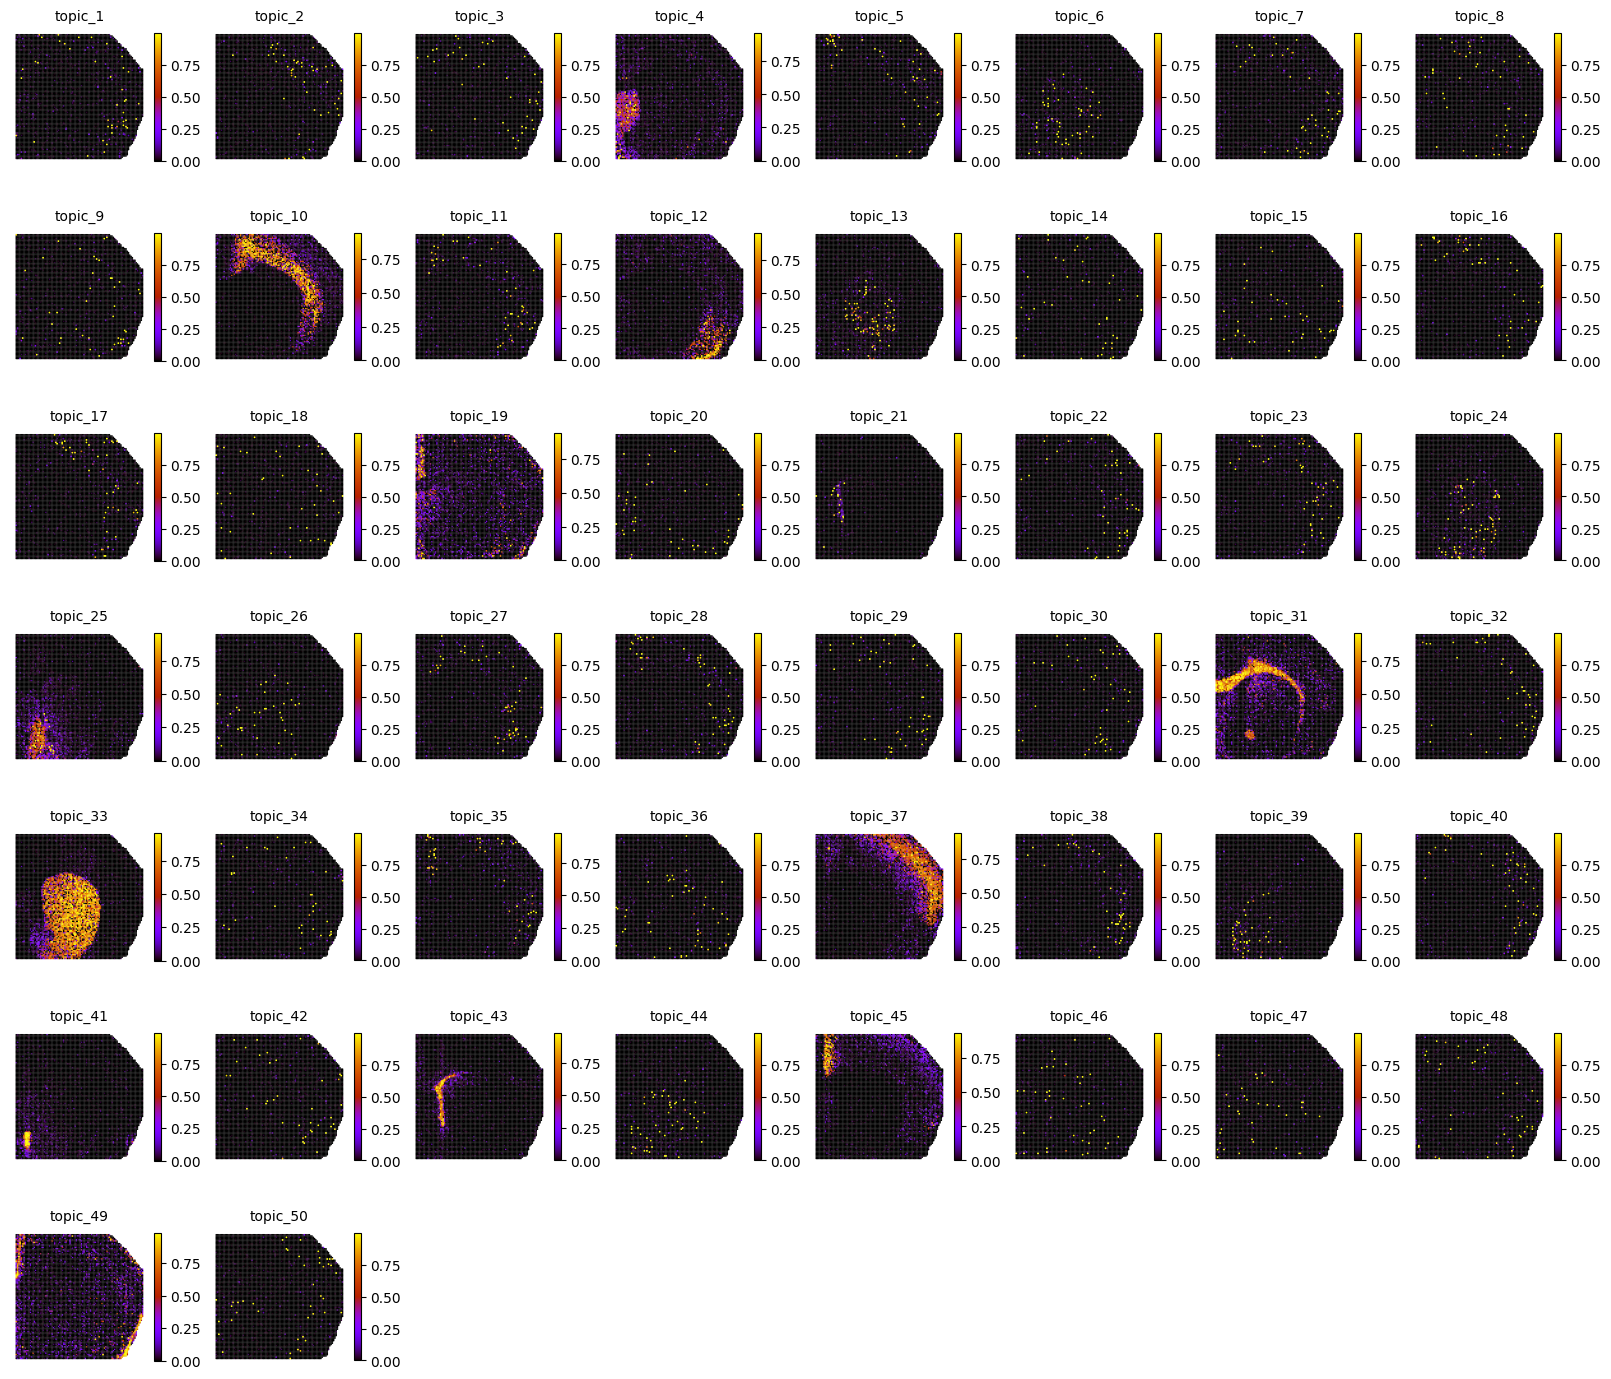

In [7]:
mtopic.pl.topics(p22, x='coords', s=6)

To visualize overall trends in topic-spot distributions, use the `mtopic.pl.dominant_topics` function. This function assigns each spot to its most dominant topic, the one with the highest probability, and colors it accordingly.

The resulting plot provides a global overview of topic dominance across the tissue, helping you quickly identify regions enriched in specific topics. These regions may correspond to distinct cell types, tissue structures, or gradients of biological activity.

This visualization is handy for detecting the tissue's spatial domains and functional zones.

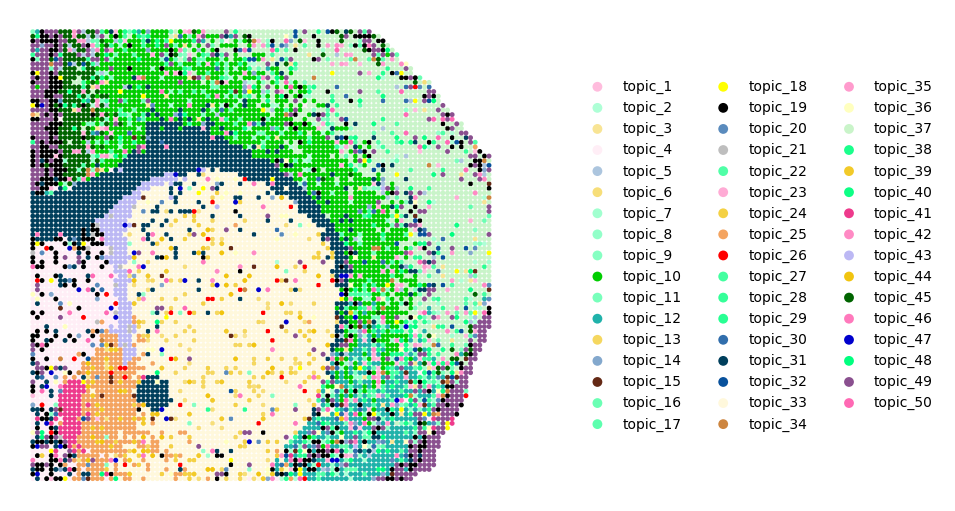

In [8]:
palette = {'topic_1': '#ffbcdd', 'topic_2': '#aeffd6', 'topic_3': '#f8e494', 'topic_4': '#ffeef6', 'topic_5': '#acc5de',
           'topic_6': '#f7de79', 'topic_7': '#a1ffcf', 'topic_8': '#93ffc9', 'topic_9': '#86ffc2', 'topic_10': '#00cd00',
           'topic_11': '#78ffbb', 'topic_12': '#20b2aa', 'topic_13': '#f5d75f', 'topic_14': '#83a8cd', 'topic_15': '#642915',
           'topic_16': '#6bffb4', 'topic_17': '#5dffae', 'topic_18': '#ffff00', 'topic_19': '#000000', 'topic_20': '#5a8bbd',
           'topic_21': '#bebebe', 'topic_22': '#50ffa7', 'topic_23': '#ffabd5', 'topic_24': '#f4d144', 'topic_25': '#f4a460',
           'topic_26': '#ff0000', 'topic_27': '#43ffa0', 'topic_28': '#35ff99', 'topic_29': '#28ff93', 'topic_30': '#316eac',
           'topic_31': '#003f5c', 'topic_32': '#08519c', 'topic_33': '#fff8dc', 'topic_34': '#cd853f', 'topic_35': '#ff9bcd',
           'topic_36': '#ffffbf', 'topic_37': '#c9f4c9', 'topic_38': '#1aff8c', 'topic_39': '#f2ca29', 'topic_40': '#0dff85',
           'topic_41': '#ee3a8c', 'topic_42': '#ff8ac4', 'topic_43': '#bcb8f4', 'topic_44': '#f1c40f', 'topic_45': '#006400',
           'topic_46': '#ff79bc', 'topic_47': '#0000cd', 'topic_48': '#00ff7f', 'topic_49': '#8a508f', 'topic_50': '#ff69b4'}

mtopic.pl.dominant_topics(p22, x='coords', s=50, figsize=(10, 5), palette=palette)

## Visualizing Feature Signatures

To interpret the results of the `sMTM` model, it is important to examine the feature signatures associated with each topic. Identifying the most relevant features for each topic provides insight into the biological identity and function of the inferred cell populations or processes.

Use the `mtopic.pl.signatures` function to visualize the top features per topic. This function generates a set of plots, each showing the most significant features ranked by their scores for a given topic.

These visualizations help reveal which molecular markers distinguish topics, aiding in biological interpretation and annotation of the results.

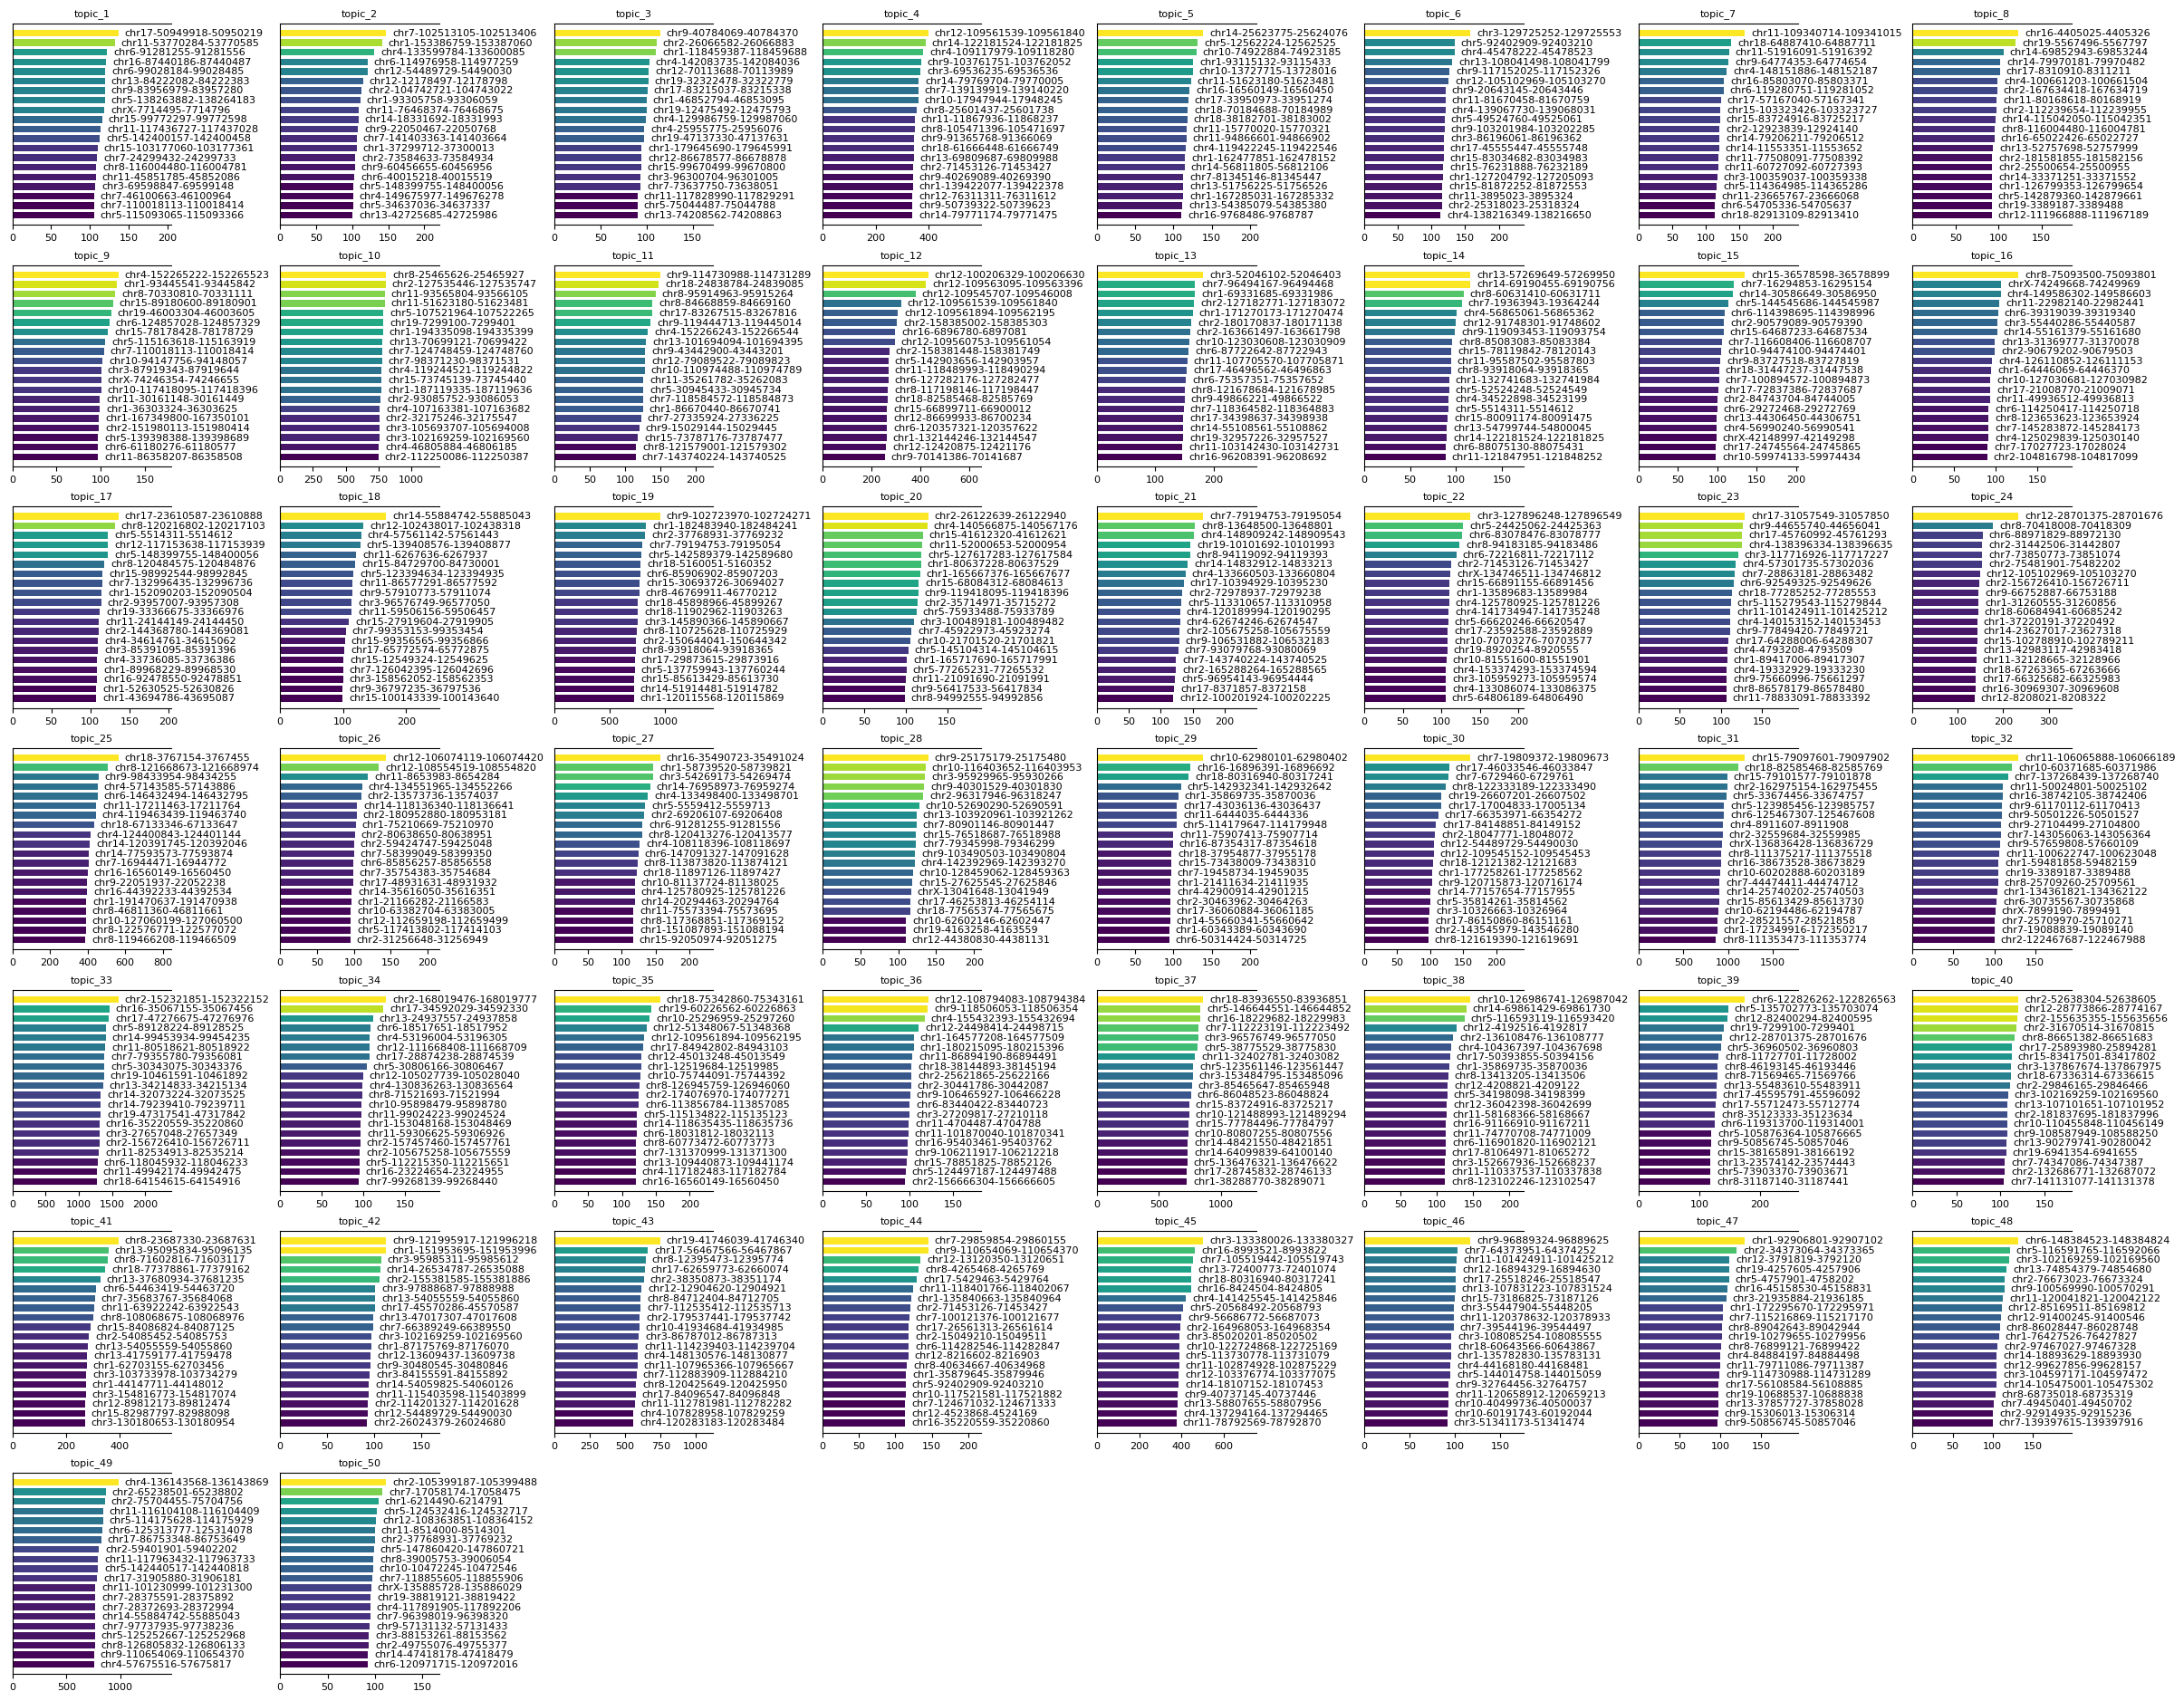

In [9]:
mtopic.pl.signatures(p22, mod='atac', n_top=20)

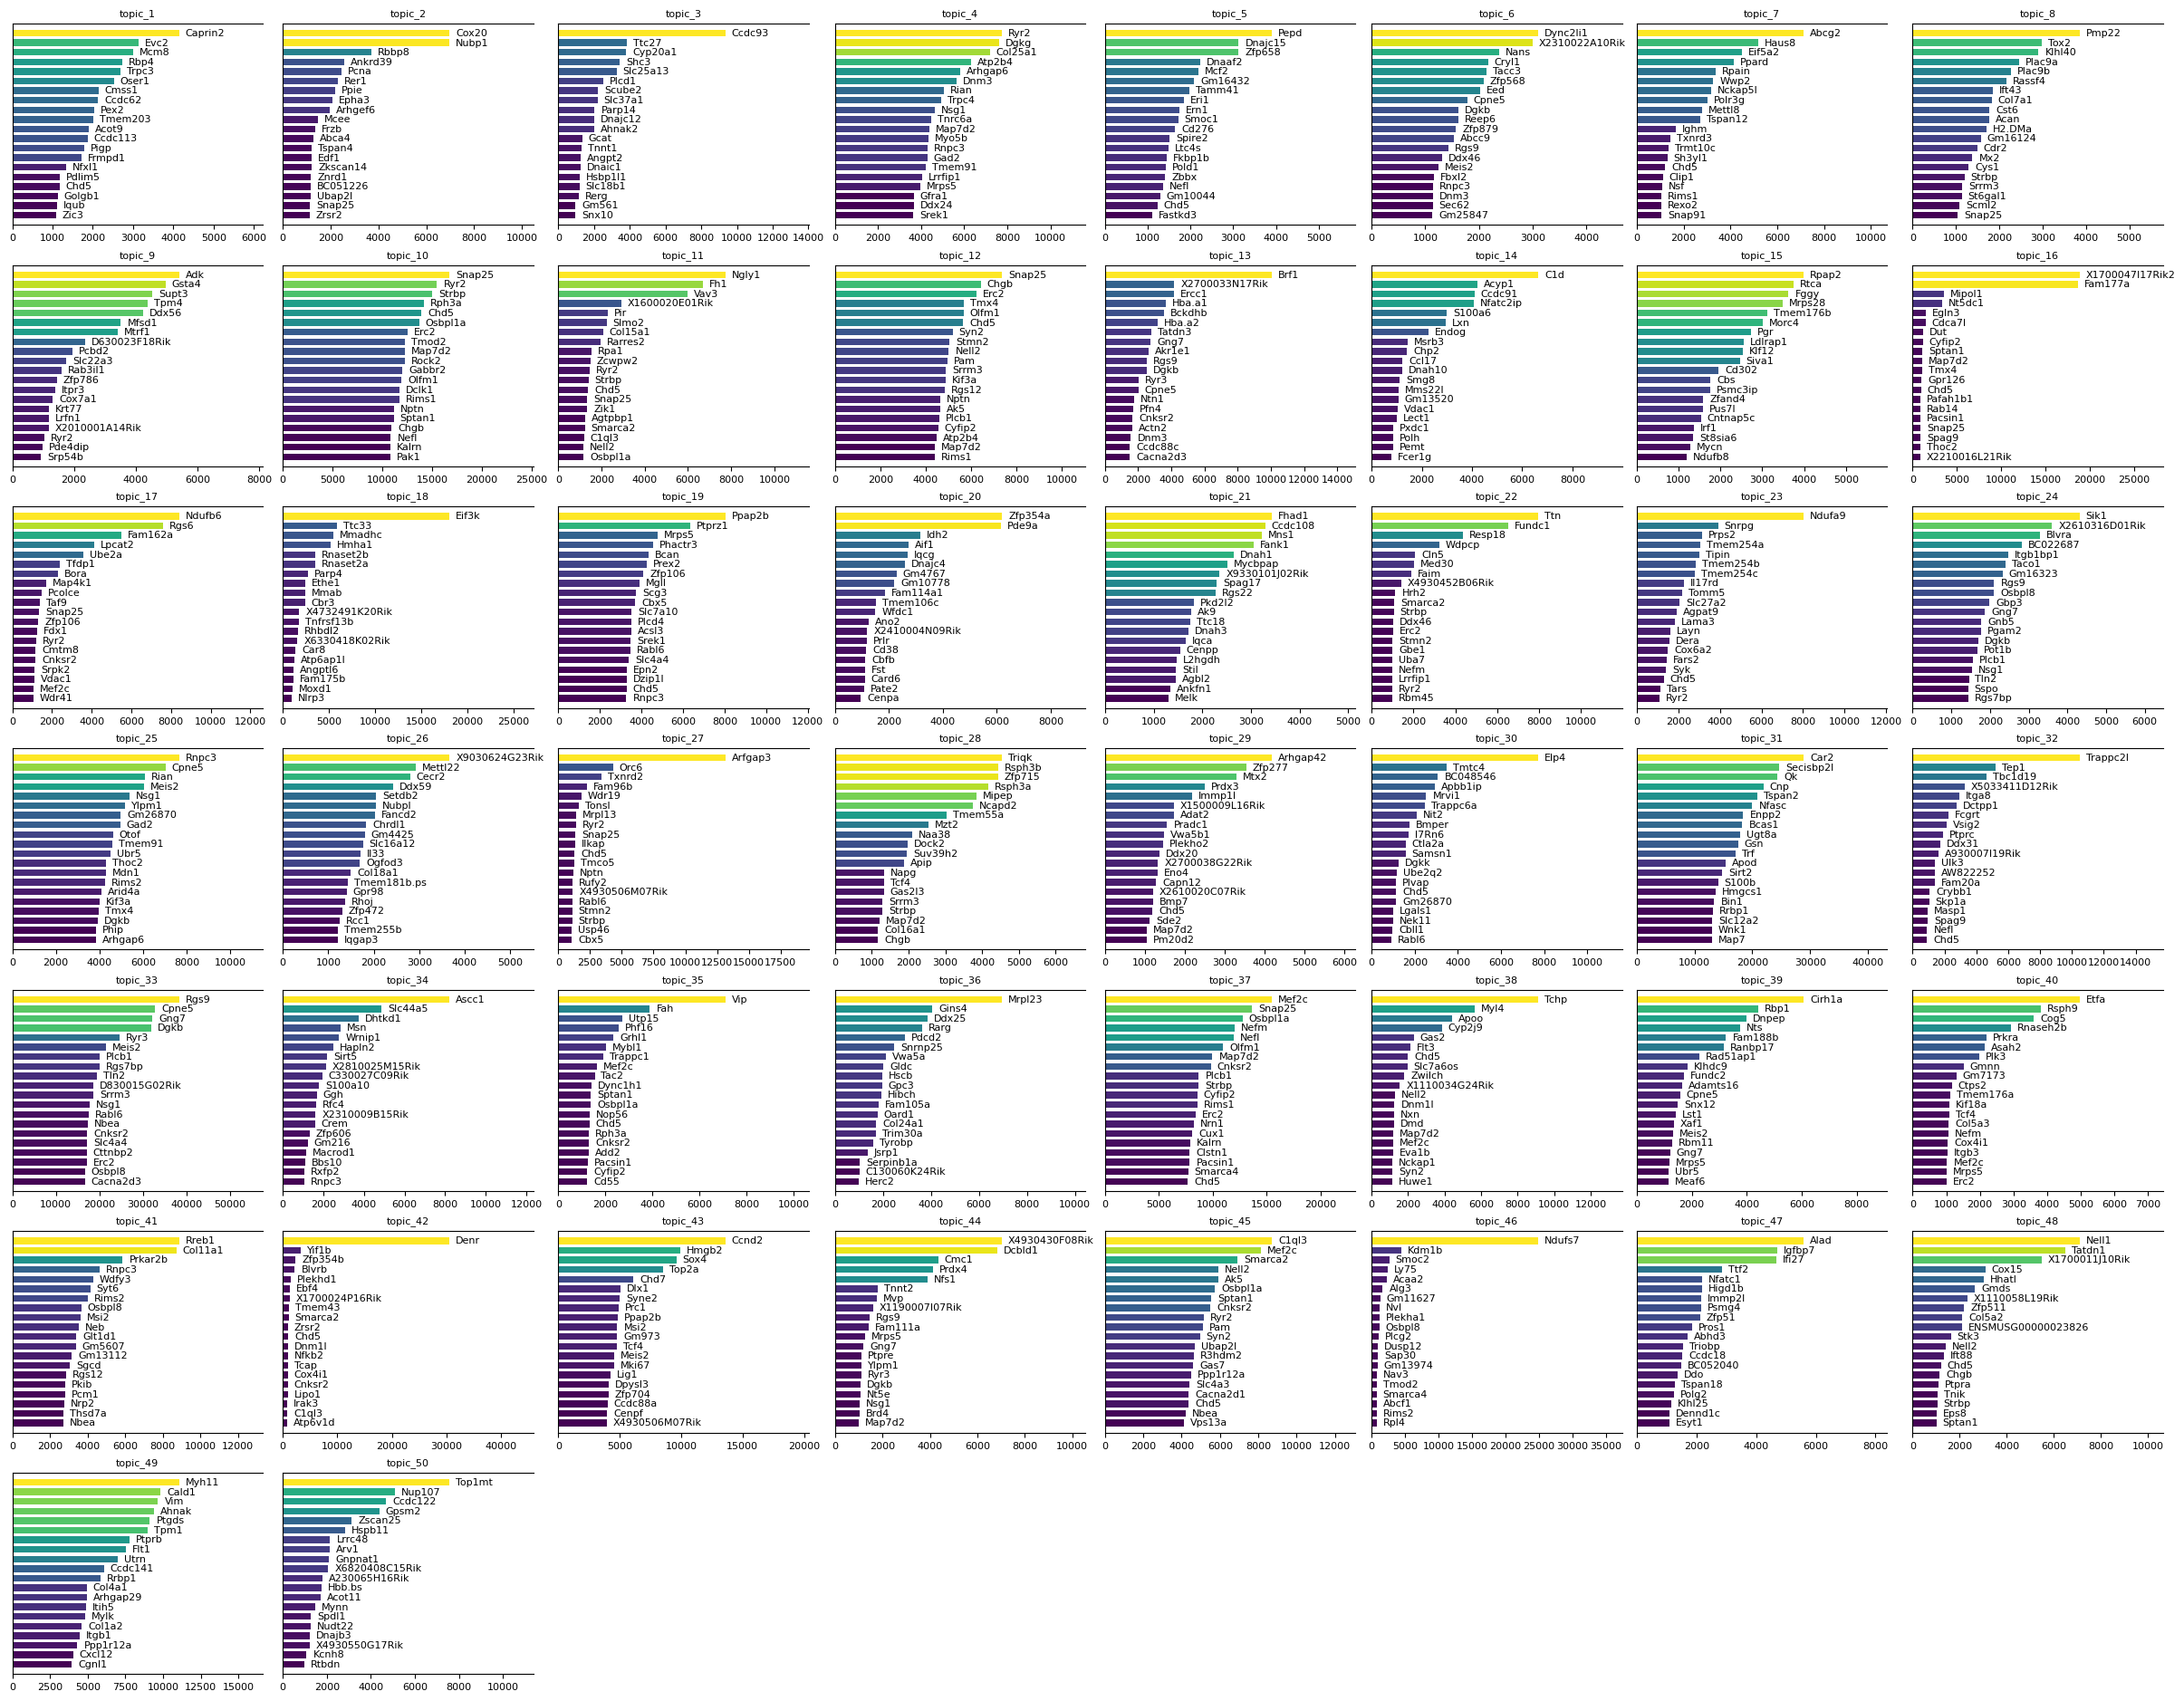

In [10]:
mtopic.pl.signatures(p22, mod='rna', n_top=20)

To better understand the spatial relevance of topic signatures and validate their biological specificity, you can visualize feature z-scores. A z-score indicates how much a feature’s expression in a given cell deviates from the mean, normalized by standard deviation. This highlights significantly up- or downregulated features in specific regions or cell populations.

Use `mtopic.tl.zscores` to compute modality-specific z-scores, and `mtopic.pl.corr_heatmap` to visualize their correlation with topic-spot distributions.

In the example below, we compute z-scores for the top 100 peaks and top 20 genes per topic to explore their spatial expression patterns.

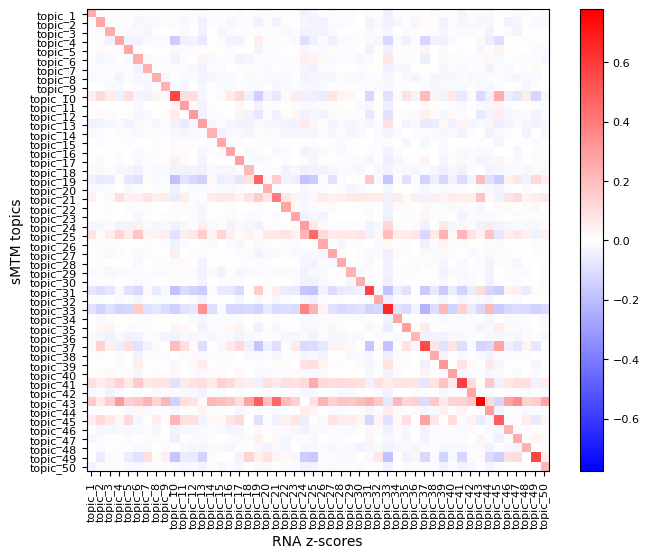

In [11]:
mtopic.tl.zscores(p22, raw_data_path='P22_Mouse_Brain_ATAC_RNA_filtered.h5mu', mod='atac', n_top=100)
mtopic.pl.corr_heatmap(arr1=p22.obsm['topics'], label1='sMTM topics', arr2=p22.mod['atac'].obsm['zscores'], label2='RNA z-scores')

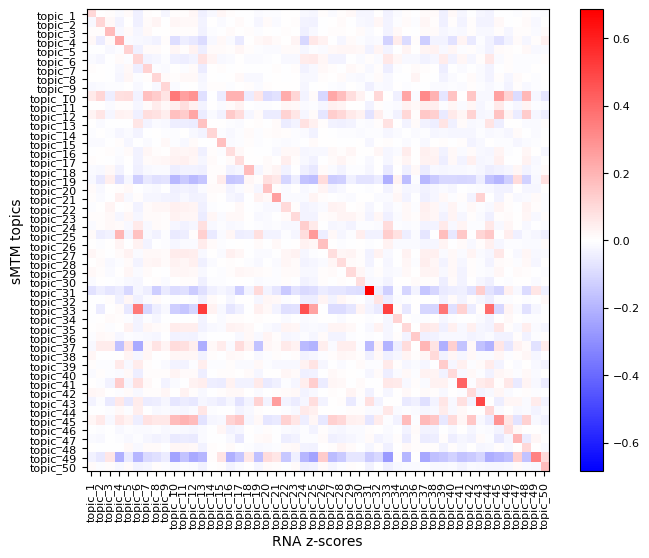

In [12]:
mtopic.tl.zscores(p22, raw_data_path='P22_Mouse_Brain_ATAC_RNA_filtered.h5mu', mod='rna', n_top=20)
mtopic.pl.corr_heatmap(arr1=p22.obsm['topics'], label1='sMTM topics', arr2=p22.mod['rna'].obsm['zscores'], label2='RNA z-scores')

This concludes the application of `mTopic` for modeling spatial multimodal single-cell data, demonstrated using the P22 mouse brain dataset. We have walked through preprocessing, topic modeling, and result interpretation, highlighting how `mTopic` enables a joint analysis across modalities with spatial context.

In [13]:
#p22.write('P22_Mouse_Brain_ATAC_RNA_trained.h5mu')